In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

In [2]:
# Load the dataset
df = pd.read_csv('../Data/selected_features.csv', parse_dates=['Date'], index_col='Date')

# Rename the target column for clarity
df.rename(columns={'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'load'}, inplace=True)

df['last_day_value'] = df['load'].shift(24)
df['last_week_value'] = df['load'].shift(168)
df['last_year_value'] = df['load'].shift(8760)

# Drop rows with NaN values
df.dropna(inplace=True)

# Inspect the data
print(df.head())
print(df.info())

                     hour  dayofyear_cos  dayofweek  dayofweek_sin  \
Date                                                                 
2019-10-31 18:00:00  18.0       0.497513        3.0       0.433884   
2019-10-31 19:00:00  19.0       0.497513        3.0       0.433884   
2019-10-31 20:00:00  20.0       0.497513        3.0       0.433884   
2019-10-31 21:00:00  21.0       0.497513        3.0       0.433884   
2019-10-31 22:00:00  22.0       0.497513        3.0       0.433884   

                     is_workday      hour_cos  date_offset  dayofyear  \
Date                                                                    
2019-10-31 18:00:00         1.0 -1.836970e-16        711.0      304.0   
2019-10-31 19:00:00         1.0  2.588190e-01        711.0      304.0   
2019-10-31 20:00:00         1.0  5.000000e-01        711.0      304.0   
2019-10-31 21:00:00         1.0  7.071068e-01        711.0      304.0   
2019-10-31 22:00:00         1.0  8.660254e-01        711.0      304.0  

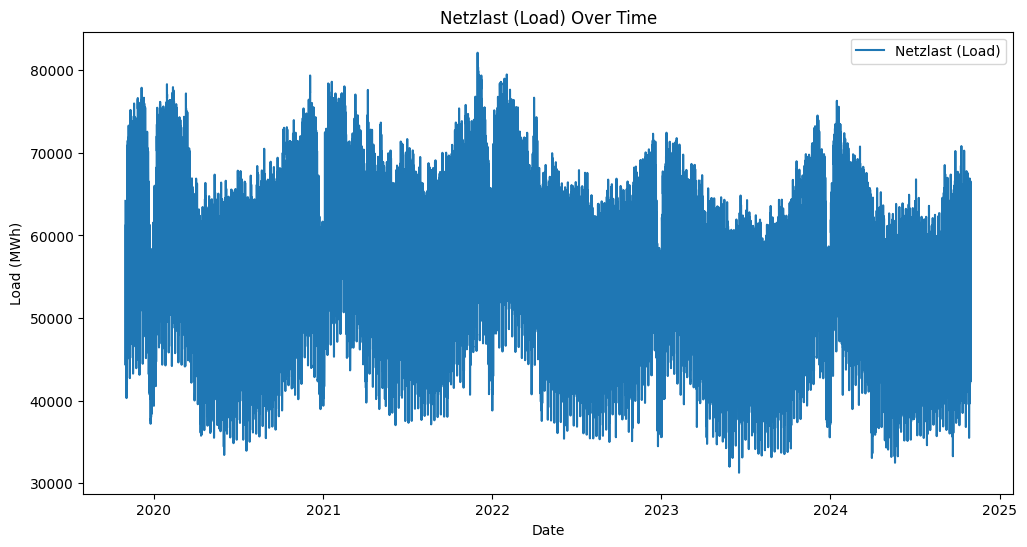

In [3]:
# Plot the target variable (Netzlast/load) over time
plt.figure(figsize=(12, 6))
plt.plot(df['load'], label='Netzlast (Load)')
plt.title('Netzlast (Load) Over Time')
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.legend()
plt.show()

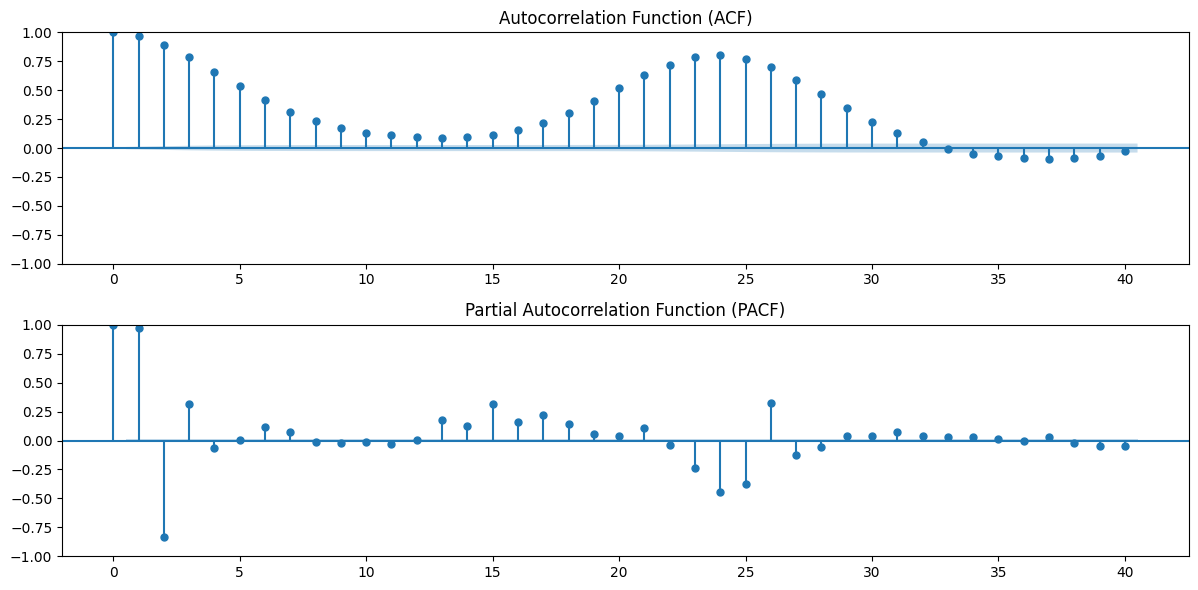

In [4]:
# ACF and PACF plots with significance
plt.figure(figsize=(12, 6))

# ACF plot with significance
plt.subplot(211)
plot_acf(df['load'], lags=40, ax=plt.gca(), alpha=0.05)
plt.title('Autocorrelation Function (ACF)')

# PACF plot with significance
plt.subplot(212)
plot_pacf(df['load'], lags=40, ax=plt.gca(), alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [5]:
# Check stationarity using the Augmented Dickey-Fuller test
adf_test = adfuller(df['load'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
if adf_test[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary. Differencing might be needed.")

ADF Statistic: -17.39951241268992
p-value: 4.956280159898939e-30
The time series is stationary.


In [6]:
# Ensure the Date column is the index and datetime type
df.index = pd.to_datetime(df.index)

# Split the dataset into training and test sets based on the specific date
train_data = df[(df.index >= pd.Timestamp('2021-09-30')) & (df.index <= pd.Timestamp('2023-09-30'))]
test_data = df[df.index > pd.Timestamp('2023-09-30')]


In [7]:
# List of significant features based on p-values < 0.05
significant_features = [
    'hour_cos', 
    'Steinkohle [MWh] Berechnete Auflösungen', 
    'hour_sin', 
    'Wind Onshore [MWh] Berechnete Auflösungen',
    'last_week_value',
    # 'last_year_value'
]

# Select the columns from the training data that correspond to significant features
X_selected = train_data[significant_features]


In [ ]:
# Train SARIMAX model (example with default order) 15MIN!
sarimax_model = SARIMAX(train_data['load'],
                        exog=X_selected,
                        order=(3, 1, 3),  # (p, d, q)
                        seasonal_order=(3, 1, 4
                                        , 24),  # (P, D, Q, s), 12 for monthly seasonality
                        enforce_stationarity=False,
                        n_jobs=-1,
                        enforce_invertibility=False)
sarimax_fitted = sarimax_model.fit(disp=False)

c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['n_jobs']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Max

In [9]:
# Initialize variables to store predictions
rolling_predictions = []

X_test = test_data[significant_features]

# Make one-step ahead forecasts using the already trained model
for i in range(len(test_data)):
    # Get the exogenous variables for the current step
    exog_test_current = X_test.iloc[i:i+1]
    
    # Make forecast for this step using the original trained model
    forecast = sarimax_fitted.get_forecast(steps=1, exog=exog_test_current)
    rolling_predictions.append(forecast.predicted_mean.values[0])

# Add predictions to test data
test_data['Rolling_Forecast'] = rolling_predictions

c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['n_jobs']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No

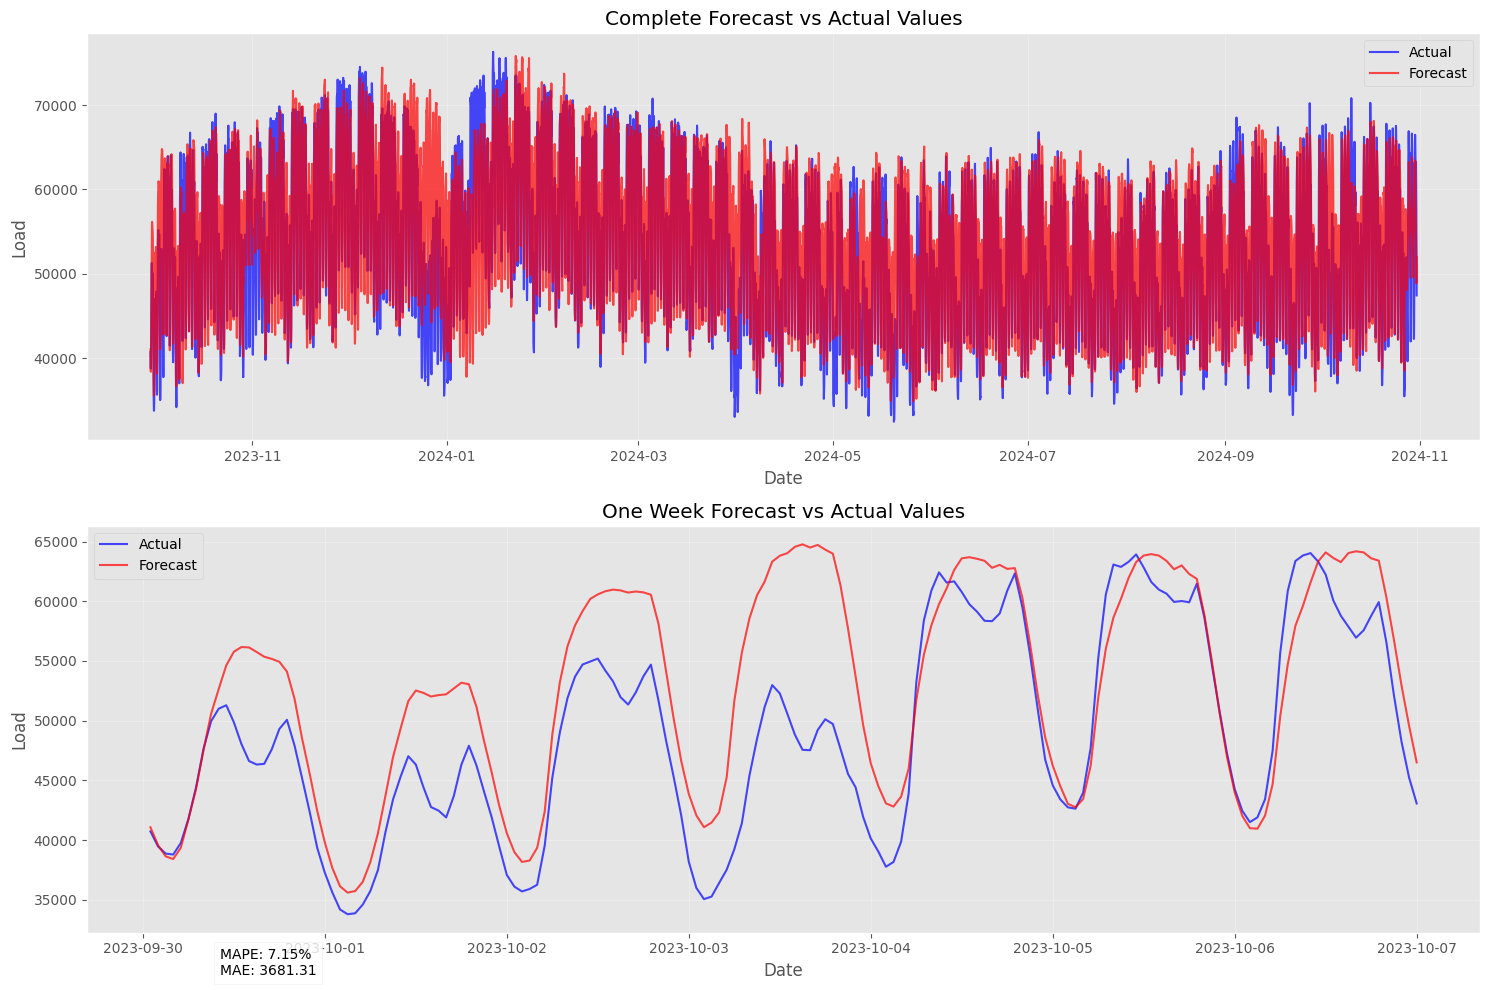

Mean Absolute Percentage Error (MAPE): 7.15%
Mean Absolute Error (MAE): 3681.31


In [10]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt

# Calculate MAPE and MAE using sklearn
mape = mean_absolute_percentage_error(test_data['load'], test_data['Rolling_Forecast']) * 100  # multiply by 100 for percentage
mae = mean_absolute_error(test_data['load'], test_data['Rolling_Forecast'])

# Create figure with subplots
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 10))

# Plot 1: Full forecast
plt.subplot(2, 1, 1)
plt.plot(test_data.index, test_data['load'], label='Actual', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data['Rolling_Forecast'], label='Forecast', color='red', alpha=0.7)
plt.title('Complete Forecast vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Load')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: One week forecast
plt.subplot(2, 1, 2)
one_week = test_data.iloc[:168]  # Assuming 24*7 hourly data points
plt.plot(one_week.index, one_week['load'], label='Actual', color='blue', alpha=0.7)
plt.plot(one_week.index, one_week['Rolling_Forecast'], label='Forecast', color='red', alpha=0.7)
plt.title('One Week Forecast vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Load')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text box with metrics
metrics_text = f'MAPE: {mape:.2f}%\nMAE: {mae:.2f}'
plt.figtext(0.15, 0.02, metrics_text, bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

# Print metrics
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

In [11]:
# Print out the model summary
print(sarimax_fitted.summary())

# -137765.405

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                17533
Model:             SARIMAX(6, 1, 4)x(4, 1, 4, 24)   Log Likelihood             -137082.678
Date:                            Wed, 19 Feb 2025   AIC                         274213.357
Time:                                    01:03:10   BIC                         274399.706
Sample:                                         0   HQIC                        274274.737
                                          - 17533                                         
Covariance Type:                              opg                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
hour_cos                                  -4020.9615

In [12]:
X_selected_test = test_data[X_selected.columns]


In [13]:
# Assuming you have the same model as before
forecast_steps = len(X_selected_test)  # Number of steps to forecast, based on your test data length

# Get forecast using the trained SARIMAX model
forecast = sarimax_fitted.get_forecast(steps=forecast_steps, exog=X_selected_test)

# Extract forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['n_jobs']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


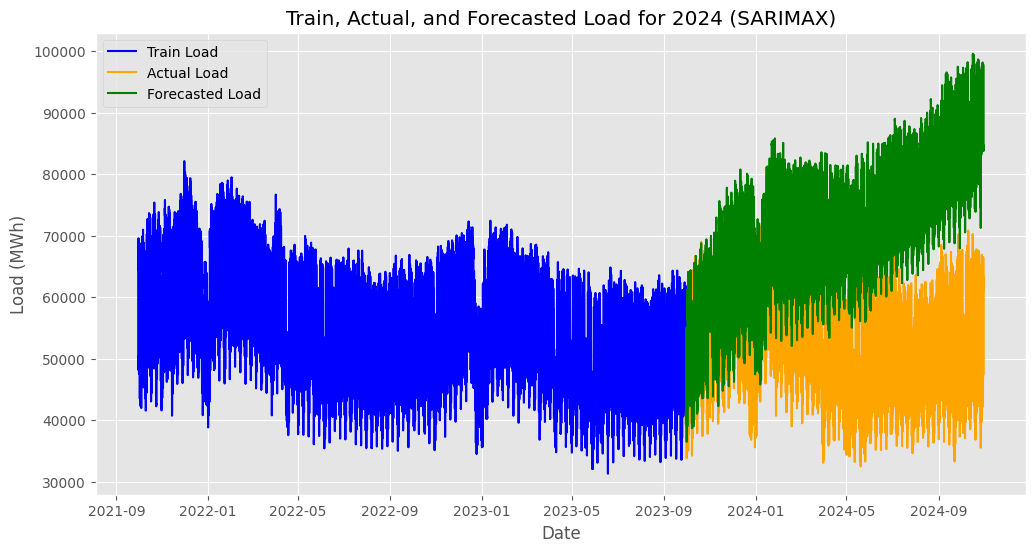

In [14]:
# Plot the training load, actual test load, and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['load'], label='Train Load', color='blue')
plt.plot(test_data.index, test_data['load'], label='Actual Load', color='orange')
plt.plot(test_data.index, forecast_mean, label='Forecasted Load', color='green')
plt.title('Train, Actual, and Forecasted Load for 2024 (SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.legend()
plt.show()


In [15]:
# Calculate the MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(test_data['load'], forecast_mean)
print(f'MAPE: {mape}')

MAPE: 0.3716163632312435


In [16]:
# Initialize variables
rolling_predictions = []
train_data_roll = train_data.copy()

# Perform rolling forecast
for t in range(len(test_data)):
    # Forecast the next value (no need to retrain the model each time)
    forecast = sarimax_fitted.get_forecast(steps=1, exog=X_selected_test.iloc[t:t+1])
    forecast_mean = forecast.predicted_mean.iloc[0]  # Use .iloc[0] instead of [0]
    
    # Append the forecast to the list
    rolling_predictions.append(forecast_mean)

c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['n_jobs']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\TimPr\allcode\energy-timeseries-project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No

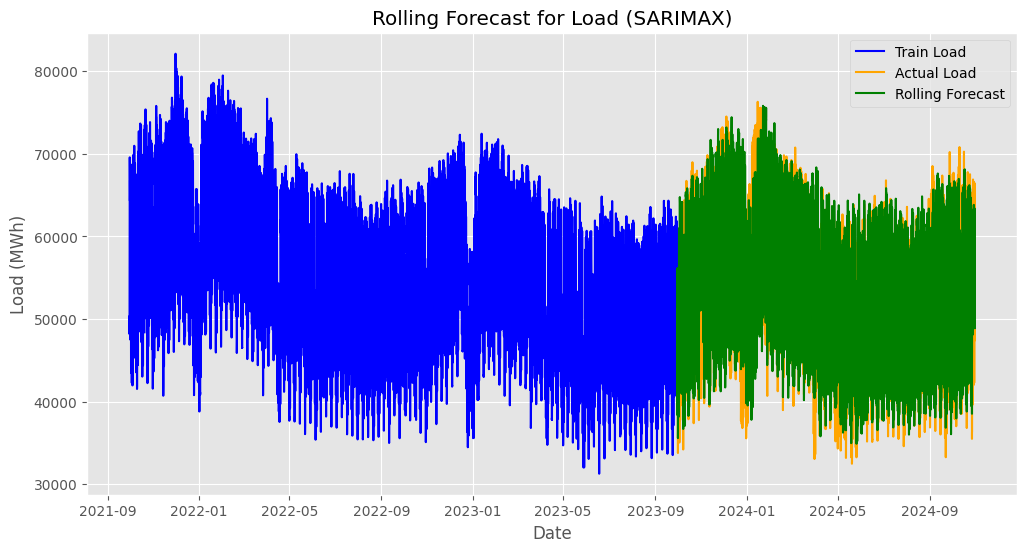

Rolling Forecasted Load for 2024:
[np.float64(41069.311093552984), np.float64(39572.46299822113), np.float64(38638.76997830298), np.float64(38410.69351405903), np.float64(39352.464983901235), np.float64(41717.460043071595), np.float64(44261.147721451474), np.float64(47534.094747736555), np.float64(50579.84498353368), np.float64(52646.00362867704), np.float64(54630.07516185206), np.float64(55771.94120911209), np.float64(56165.63029171793), np.float64(56130.75401987987), np.float64(55749.30286135111), np.float64(55354.326529205166), np.float64(55170.88709720677), np.float64(54930.864943930734), np.float64(54106.458252997036), np.float64(51832.64002534335), np.float64(48490.18286494398), np.float64(45555.45329701975), np.float64(42426.143087535675), np.float64(39787.11853348612), np.float64(37639.12154031826), np.float64(36130.16821534124), np.float64(35598.29019704376), np.float64(35730.90594994704), np.float64(36502.0091334243), np.float64(38158.12214660116), np.float64(40563.1154135909

In [17]:
# Plot the actual load and the rolling forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['load'], label='Train Load', color='blue')
plt.plot(test_data.index, test_data['load'], label='Actual Load', color='orange')
plt.plot(test_data.index, rolling_predictions, label='Rolling Forecast', color='green')
plt.title('Rolling Forecast for Load (SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.legend()
plt.show()

# Print out the rolling predictions
print("Rolling Forecasted Load for 2024:")
print(rolling_predictions)


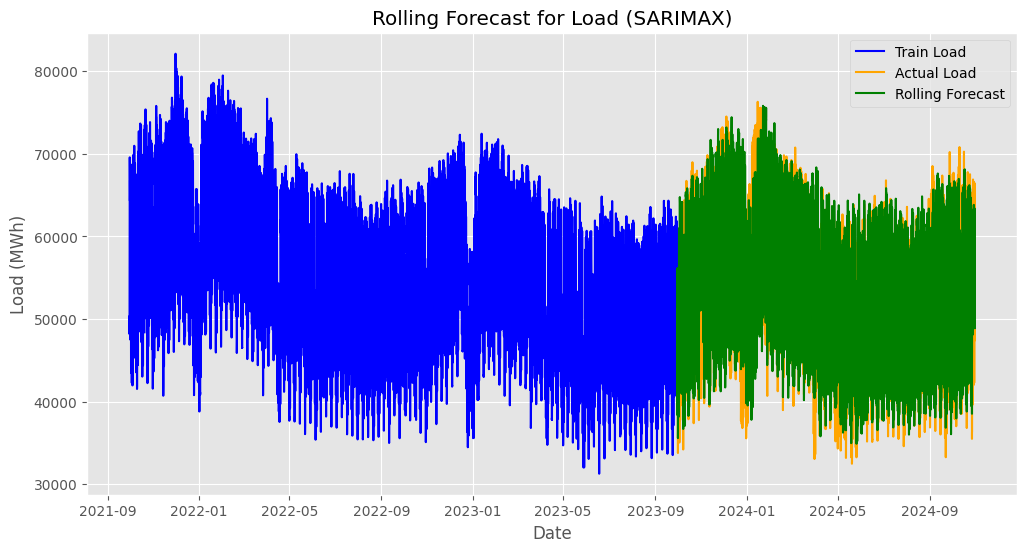

Rolling Forecasted Load for 2024:
[np.float64(41069.311093552984), np.float64(39572.46299822113), np.float64(38638.76997830298), np.float64(38410.69351405903), np.float64(39352.464983901235), np.float64(41717.460043071595), np.float64(44261.147721451474), np.float64(47534.094747736555), np.float64(50579.84498353368), np.float64(52646.00362867704), np.float64(54630.07516185206), np.float64(55771.94120911209), np.float64(56165.63029171793), np.float64(56130.75401987987), np.float64(55749.30286135111), np.float64(55354.326529205166), np.float64(55170.88709720677), np.float64(54930.864943930734), np.float64(54106.458252997036), np.float64(51832.64002534335), np.float64(48490.18286494398), np.float64(45555.45329701975), np.float64(42426.143087535675), np.float64(39787.11853348612), np.float64(37639.12154031826), np.float64(36130.16821534124), np.float64(35598.29019704376), np.float64(35730.90594994704), np.float64(36502.0091334243), np.float64(38158.12214660116), np.float64(40563.1154135909

In [18]:
# Plot the actual load and the rolling forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['load'], label='Train Load', color='blue')
plt.plot(test_data.index, test_data['load'], label='Actual Load', color='orange')
plt.plot(test_data.index, rolling_predictions, label='Rolling Forecast', color='green')
plt.title('Rolling Forecast for Load (SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.legend()
plt.show()

# Print out the rolling predictions
print("Rolling Forecasted Load for 2024:")
print(rolling_predictions)


In [19]:
# Calculate MAPE using the sklearn function
mape = mean_absolute_percentage_error(test_data['load'].iloc[:len(rolling_predictions)], rolling_predictions)

# Print MAPE
print(f"MAPE of the Rolling Forecast: {mape * 100:.2f}%")

MAPE of the Rolling Forecast: 7.15%
